In [1]:
import keras 
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,merge
from keras.layers import LSTM,GRU
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.models import Sequential,Model

from functools import reduce
import tarfile 
import numpy as np
import re

Using TensorFlow backend.


In [2]:
train_model=0
train_epochs=100
load_model=1
batch_size=32
lstm_size=64
test_qualitative=0
user_question=1

In [3]:
def tokenize(sent):
    return [x.strip() for x in re.split("(\W+)?",sent) if x.strip()]

In [4]:
def parse_stories(lines,only_supporting=False):
    
    data=[]
    story=[]
    
    for line in lines:
        line=line.strip()
        nid,line=line.split(" ",1)
        nid=int(nid)
        
        if nid==1:
            story=[]
        if "\t" in line:
            q,a,supporting=line.split("\t")
            q=tokenize(q)
            substory=None
            
            if only_supporting:
                supporting=map(int,supporting.split())
                substory=[story[i-1] for i in supporting]
            else:
                substory=[x for x in story if x]
            
            data.append((substory,q,a))
            story.append("")
        else:
            sent=tokenize(line)
            story.append(sent)
    return data

In [5]:
def get_stories(f,only_supporting=False,max_length=None):
    
    data=parse_stories(f.readlines(),only_supporting=only_supporting)
    flatten=lambda data:reduce(lambda x, y:x+y,data)
    data=[(flatten(story),q,answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    
    return data
    

In [6]:
train_path="tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_train.txt"
test_path="tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_test.txt"

In [7]:
train_file=open(train_path) 
test_file=open(test_path)

In [8]:
train_stories=get_stories(train_file)
test_stories=get_stories(test_file)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [9]:
train_stories[1]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.',
  'Daniel',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.',
  'Sandra',
  'moved',
  'to',
  'the',
  'garden',
  '.'],
 ['Where', 'is', 'Daniel', '?'],
 'hallway')

In [10]:
vocab=set()
#vocab1=set()

for story, q, answer in train_stories+test_stories:
    vocab|=set(story+q+[answer])
    #vocab1=set(story+q+[answer])
vocab=sorted(vocab)

In [11]:
# reserve 0 for masking via pad_sequences

vocab_size=len(vocab)+1
story_maxlen=max(map(len,(x for x,_,_ in train_stories+test_stories)))
query_maxlen=max(map(len,(x for _,x,_ in train_stories+ test_stories)))

In [28]:
word_idx=dict((y,x+1) for x,y in enumerate(vocab))
idx_word=dict((i+1,c) for i,c in enumerate(vocab))

In [13]:
def vectorize_stories(data,word_idx,story_maxlen,query_maxlen):
    X=[]
    Xq=[]
    Y=[]
    for story,query,answer in data:
        x=[word_idx[w] for w in story]
        xq=[word_idx[w] for w in query]
        y=np.zeros(len(word_idx)+1)
        y[word_idx[answer]]=1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X,maxlen=story_maxlen),
           pad_sequences(Xq,maxlen=query_maxlen),np.array(Y))

In [14]:
inputs_train,queries_train,answers_train=vectorize_stories(train_stories,
                                                           word_idx,
                                                           story_maxlen,
                                                           query_maxlen)

In [15]:
inputs_test,queries_test,answers_test=vectorize_stories(test_stories,
                                                           word_idx,
                                                           story_maxlen,
                                                           query_maxlen)

In [16]:
inputs_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  5, 16, 19, 18,  9,  1,  4, 21, 19, 18, 12,  1],
      dtype=int32)

In [17]:
# placeholders
input_sequence=Input((story_maxlen,))
question=Input((query_maxlen,))

In [18]:
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                             output_dim=64))
input_encoder_m.add(Dropout(0.3))

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                             output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))

# embed the question into a sequence of vectors
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                              output_dim=64,
                              input_length=query_maxlen))
question_encoder.add(Dropout(0.3))


In [19]:
input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 68, 64), dtype=float32)
Input encoded c Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 68, 4), dtype=float32)
Question encoded Tensor("sequential_3/dropout_3/cond/Merge:0", shape=(?, 4, 64), dtype=float32)


In [20]:
# compute a 'match' between the first input vector sequence and the question vector sequence
match=merge.Dot(axes=(2,2))([input_encoded_m,question_encoded])
match=Activation("softmax")(match)
match

<tf.Tensor 'activation_1/truediv:0' shape=(?, 68, 4) dtype=float32>

In [21]:
# add the match matrix with the second input vector sequence
response=merge.Add()([match,input_encoded_c])# (samples, story_maxlen, query_maxlen)
response=Permute((2,1))(response)# (samples, query_maxlen, story_maxlen)
response

<tf.Tensor 'permute_1/transpose:0' shape=(?, 4, 68) dtype=float32>

In [22]:
answer=merge.Concatenate()([response,question_encoded])
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 4, 132) dtype=float32>

In [23]:
answer=LSTM(lstm_size)(answer)
answer=Dropout(0.3)(answer)
answer=Dense(vocab_size)(answer)
answer=Activation("softmax")(answer)

In [24]:
model=Model([input_sequence,question],answer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             1408        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4, 64)        1408        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

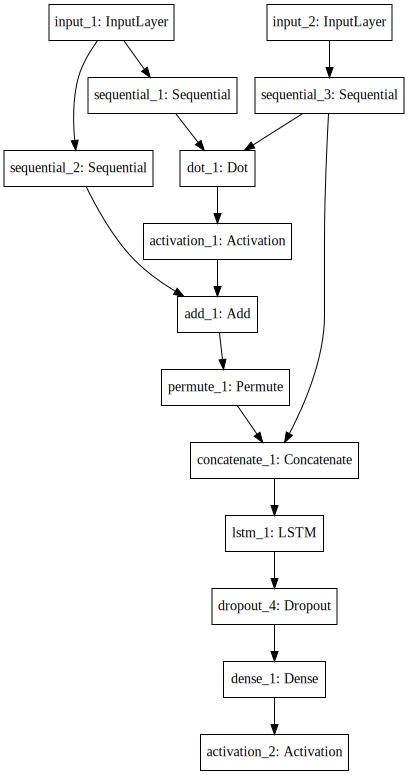

In [25]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog="dot",format="svg"))

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 7s 693us/step - loss: 1.8839 - acc: 0.1695 - val_loss: 1.7933 - val_acc: 0.1960
Epoch 2/100
10000/10000 [==============================] - 6s 625us/step - loss: 1.6767 - acc: 0.3071 - val_loss: 1.6034 - val_acc: 0.3520
Epoch 3/100
10000/10000 [==============================] - 6s 633us/step - loss: 1.5256 - acc: 0.4004 - val_loss: 1.4736 - val_acc: 0.4280
Epoch 4/100
10000/10000 [==============================] - 6s 628us/step - loss: 1.4960 - acc: 0.4068 - val_loss: 1.5076 - val_acc: 0.3900
Epoch 5/100
10000/10000 [==============================] - 6s 619us/step - loss: 1.4693 - acc: 0.4127 - val_loss: 1.4049 - val_acc: 0.4520
Epoch 6/100
10000/10000 [==============================] - 6s 608us/step - loss: 1.4238 - acc: 0.4338 - val_loss: 1.3625 - val_acc: 0.4520
Epoch 7/100
10000/10000 [==============================] - 6s 611us/step - loss: 1.3949 - acc: 0.4453 - val_loss: 1.3

In [31]:
for i in range(0,2):
    current_inp=test_stories[i]
    current_story,current_query,current_answer=vectorize_stories([current_inp],word_idx,
                                                                story_maxlen,query_maxlen)
    current_prediction=model.predict([current_story,current_query])
    current_prediction=idx_word[np.argmax(current_prediction)]
    print("History:"," ".join(current_inp[0])," ".join(current_inp[1]),"| Prediction:",
         current_prediction ,"|Ground Truth:",current_inp[2])

History: John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: hallway |Ground Truth: hallway
History: John travelled to the hallway . Mary journeyed to the bathroom . Daniel went back to the bathroom . John moved to the bedroom . Where is Mary ? | Prediction: bathroom |Ground Truth: bathroom
